# Evaluation

### Imports

In [41]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

### Get data

In [2]:
data_url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [3]:
!wget $data_url

--2025-10-21 22:24:52--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.1’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.03s   

2025-10-21 22:24:52 (2.42 MB/s) - ‘course_lead_scoring.csv.1’ saved [80876/80876]



### Data preparation

In [4]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [5]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [6]:
categorical = ['lead_source', 'industry', 'employment_status', 'location',]
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score',]
all_features = categorical + numerical

In [7]:
df[all_features].isnull().sum()

lead_source                 128
industry                    134
employment_status           100
location                     63
number_of_courses_viewed      0
annual_income               181
interaction_count             0
lead_score                    0
dtype: int64

In [8]:
df[categorical] = df[categorical].fillna('NA')

In [9]:
df[numerical] = df[numerical].fillna(0.0)

In [10]:
df[all_features].isnull().sum()

lead_source                 0
industry                    0
employment_status           0
location                    0
number_of_courses_viewed    0
annual_income               0
interaction_count           0
lead_score                  0
dtype: int64

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [13]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- ---
- **`number_of_courses_viewed`**
- ---
- `interaction_count`
- `annual_income`

In [16]:
for feature in numerical:
    auc = roc_auc_score(df_train.converted, df_train[feature])
    print(f"{feature}: AUC = {auc:.3f}")

number_of_courses_viewed: AUC = 0.764
annual_income: AUC = 0.552
interaction_count: AUC = 0.738
lead_score: AUC = 0.614


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- ---
- **0.72**
- ---
- 0.92

In [17]:
df_train.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

In [18]:
def prepare_data_set(X, y_column):
    X = X.reset_index(drop=True)
    y = X[y_column].values
    del X[y_column]
    return X, y

df_train, y_train = prepare_data_set(df_train, 'converted')
df_val, y_val = prepare_data_set(df_val, 'converted')
df_test, y_test = prepare_data_set(df_test, 'converted')

In [19]:
df_train.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score'],
      dtype='object')

In [47]:
def train(df_train, y_train, C=1.0):
    train_dicts = df_train[all_features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict(df, dv, model):
    dicts = df[all_features].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [27]:
dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)
auc = roc_auc_score(y_val, y_pred)
print(f'{auc:.2f}')

0.82


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* ---
* **0.745**
* ---

In [29]:
scores = []
thresholds = np.linspace(0, 1, 101)
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [32]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [33]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall
0,0.0,171,122,0,0,1.000000,1.000000,0.583618,1.000000
10,0.1,171,122,0,0,1.000000,1.000000,0.583618,1.000000
20,0.2,171,122,0,0,1.000000,1.000000,0.583618,1.000000
30,0.3,171,119,0,3,1.000000,0.975410,0.589655,1.000000
40,0.4,171,105,0,17,1.000000,0.860656,0.619565,1.000000
50,0.5,164,81,7,41,0.959064,0.663934,0.669388,0.959064
60,0.6,150,53,21,69,0.877193,0.434426,0.738916,0.877193
70,0.7,106,25,65,97,0.619883,0.204918,0.809160,0.619883
80,0.8,64,6,107,116,0.374269,0.049180,0.914286,0.374269
90,0.9,24,1,147,121,0.140351,0.008197,0.960000,0.140351


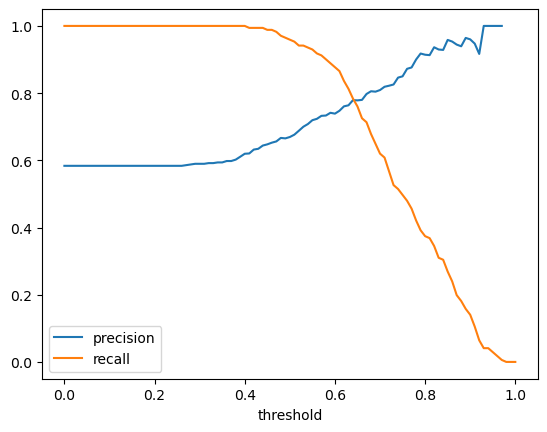

In [36]:
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')
plt.xlabel('threshold')
plt.legend()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- ---
- **0.54**
- ---
- 0.74

In [37]:
df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

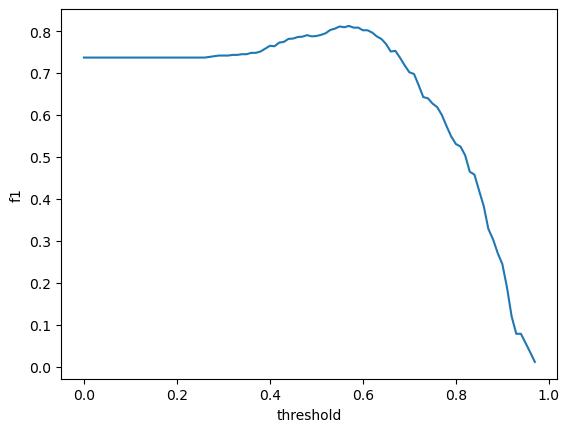

In [40]:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xlabel('threshold')
plt.ylabel('f1')
plt.show()

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- ---
- **0.06**
- ---
- 0.36

In [46]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
std = np.std(scores)
print(f'{std:.3f}')

0.036


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- ---
- **0.001**
- ---
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [48]:
for C in [0.000001, 0.001, 1]:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    mean = np.mean(scores)
    print(f'{C}: {mean:.3f}')

1e-06: 0.560
0.001: 0.867
1: 0.822
